In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
import gc

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
def seed_everything(seed=0):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
SEED = 42
seed_everything(SEED)


In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
#df = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/train.csv'))
df = reduce_mem_usage(pd.read_csv('train.csv'))
df_test = reduce_mem_usage(pd.read_csv('test.csv'))

Memory usage of dataframe is 267.04 MB
Memory usage after optimization is: 60.95 MB
Decreased by 77.2%
Memory usage of dataframe is 70.78 MB
Memory usage after optimization is: 16.49 MB
Decreased by 76.7%


In [49]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [50]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [51]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_FE'] = train_df[col].map(fq_encode)
            print(train_df[col+'_FE'].sort_index().head())
            test_df[col+'_FE']  = test_df[col].map(fq_encode)
    return train_df, test_df
#encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

In [7]:
cat_cols =  list(df.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('txkey')
cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
encode_LE(cat_cols,df,df_test)
df['flg_3dsmk'].value_counts(dropna=False, normalize=True).head()

0    0.949454
1    0.042279
2    0.008267
Name: flg_3dsmk, dtype: float64

In [8]:
print('No Frauds', round(df['fraud_ind'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['fraud_ind'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
df['fraud_ind'].value_counts()
print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))

No Frauds 98.66 % of the dataset
Frauds 1.34 % of the dataset
testdata = 421665
1.34% of testdata = 5650.0


In [9]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')
#encode_CB('stocn','scity',df,df_test)
#encode_CB('mcc','mchno',df,df_test)
#encode_CB('bacno','cano',df,df_test)
#encode_CB('scity','csmcu',df,df_test)
#encode_CB('etymd','csmcu',df,df_test)
#encode_CB('acqic','etymd',df,df_test)
#df['stocn_scity'].value_counts(dropna=False, normalize=True)

In [10]:
# GROUP AGGREGATION MEAN AND STD
def group_ag(by_group_col,groupby_col,df1,df2,fillna=True):
    nm_mean = by_group_col+'_'+groupby_col+'_mean'
    nm_std = by_group_col+'_'+groupby_col+'_std'
    df1[nm_mean] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
    df1[nm_std] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
    df2[nm_mean] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
    df2[nm_std] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
    if fillna:
        df1[nm_mean].fillna(-1,inplace=True)
        df1[nm_std].fillna(-1,inplace=True)
        df2[nm_mean].fillna(-1,inplace=True)
        df2[nm_std].fillna(-1,inplace=True)
    print(nm_mean,', ',end='')
    print(nm_std,', ',end='')
#group_ag('stocn','scity',df,df_test)
#group_ag('stocn','scity',df,df_test)
#df['stocn_scity_mean'].value_counts(dropna=False, normalize=False).head(5)
#df['stocn_scity_std'].value_counts(dropna=False, normalize=False).head(5)

In [11]:
def change_time(data):
    time = data['loctm']
    hour = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second

In [12]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    #data['conam_log'] = log
    data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [52]:
change_time(df)
change_time(df_test)
df.columns
import copy
df_backup = copy.copy(df)
df_test_backup = copy.copy(df_test)

In [0]:
a =['conam']
b =['insfg_iterm','bacno_cano','stocn_scity','ovrlt']
for i in range(len(a)): 
    for j in range(len(b)):
        #if(j>len(a)-1):
        #    break
        #if(i!=j):
           print(a[i],b[j])
   

In [0]:
#b =['insfg_iterm','bacno_cano','stocn_scity','ovrlt']
for i in range(1,len(b.columns)):
    for j in range(i+1,(len(b.columns)-1)):       
        if(i!=j):
            print(a[i],b[j])

從這開始


In [ ]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
df.columns


In [73]:
#新特徵
money_process(df)
money_process(df_test)
#encode_CB('insfg','iterm',df,df_test)
encode_CB('bacno','cano',df,df_test)
encode_CB('mcc','csmcu',df,df_test)
encode_CB('scity','mchno',df,df_test)
encode_CB('stocn','scity',df,df_test)
encode_CB('conam','contp',df,df_test)


bacno_cano , mcc_csmcu , stocn_scity , conam_contp , 

In [19]:
#group_ag('conam','stocn_scity',df,df_test)

['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flg_3dsmk', 'hcefg', 'iterm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'loctm_hour', 'loctm_min', 'bacno_cano', 'mcc_csmcu', 'stocn_scity', 'conam_contp']


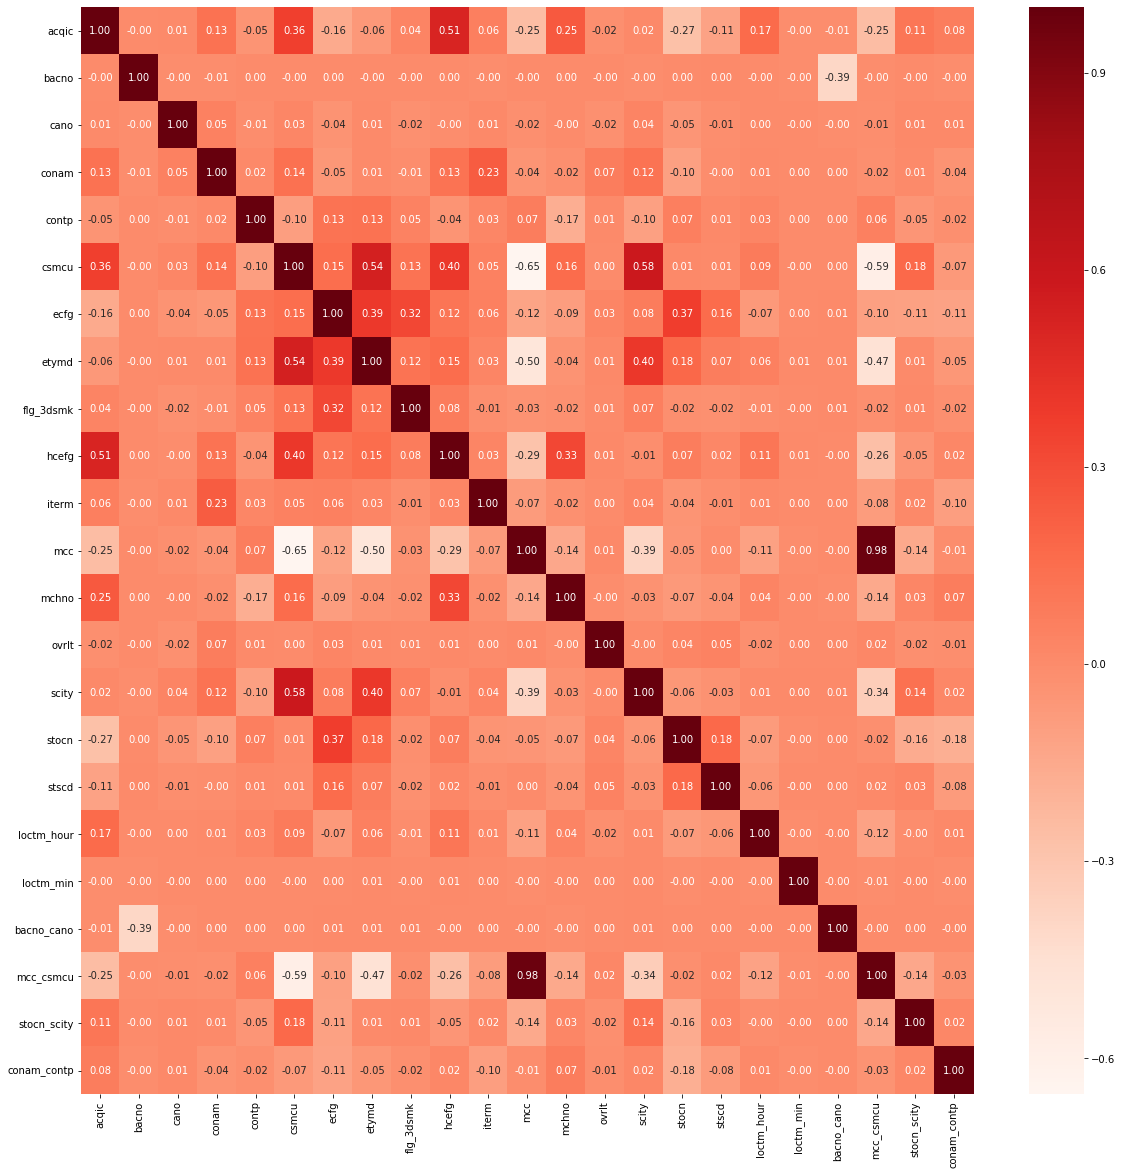

In [76]:
# 取出需要的特征
model1_features =  list(df.columns)
model1_features.remove('txkey')
model1_features.remove('locdt')
model1_features.remove('loctm')
#############################
model1_features.remove('bacno_cano')
model1_features.remove('loctm_s')
model1_features.remove('flbmk')
model1_features.remove('insfg')
#model1_features.remove('iterm')
##########################################
model1_features.remove('fraud_ind')
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
print(model1_features)
#print(X_train.columns)
show_cor(X_train)

In [77]:
# TRAIN 75% PREDICT 25%
idxT = df.index[:3*len(X_train)//4]
idxV = df.index[3*len(X_train)//4:]


In [78]:
params = {'num_leaves': 499,
          'min_child_weight': 0.009009297771374483,
          'feature_fraction': 0.8931730501715401,
          'bagging_fraction': 0.8249551970384116,
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 1.1690935357787136,
          'reg_lambda': 1.119698800271026,         
          'random_state': 1337, 
          'n_jobs':-1,
          'device': 'cpu',
           'seed': SEED,
          #'gpu_platform_id': 1,
          #'gpu_device_id': 0
         }

In [79]:
#script for time consistency
#b = list(X_train.columns)# script
#print('All feature =',X_train.columns)# script
#for i in range(len(b)):# script
#    model1_features = [b[i]]#script

All feature = Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flg_3dsmk', 'hcefg', 'iterm', 'mcc', 'mchno', 'ovrlt', 'scity',
       'stocn', 'stscd', 'loctm_hour', 'loctm_min', 'bacno_cano', 'mcc_csmcu',
       'stocn_scity', 'conam_contp'],
      dtype='object')
train feature =  ['acqic']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.942374	valid_1's auc: 0.939445
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.942374	valid_1's auc: 0.939445
  auc =  0.9394451963630737


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


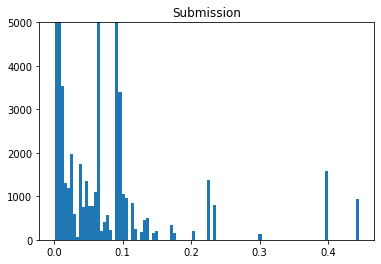

____________________________________________________________________________________________________
train feature =  ['bacno']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.581635	valid_1's auc: 0.565363
Did not meet early stopping. Best iteration is:
[49]	training's auc: 0.581635	valid_1's auc: 0.565367
  auc =  0.5653667249158763


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


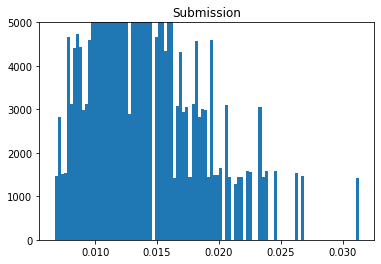

____________________________________________________________________________________________________
train feature =  ['cano']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.599054	valid_1's auc: 0.588829
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.599054	valid_1's auc: 0.588829
  auc =  0.5888292580533135


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


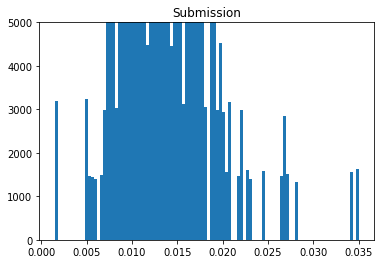

____________________________________________________________________________________________________
train feature =  ['conam']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.804055	valid_1's auc: 0.789032
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.804055	valid_1's auc: 0.789032
  auc =  0.7890321793469848


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


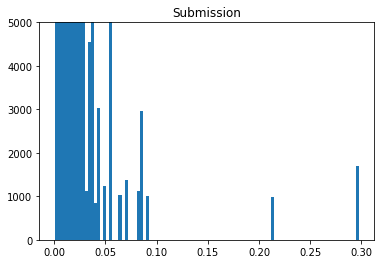

____________________________________________________________________________________________________
train feature =  ['contp']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.532389	valid_1's auc: 0.529518
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.532389	valid_1's auc: 0.529518
  auc =  0.529517626503146


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


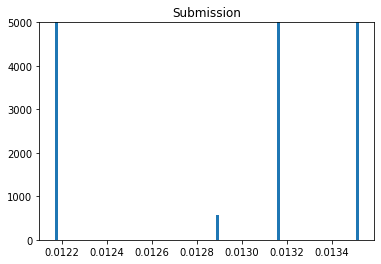

____________________________________________________________________________________________________
train feature =  ['csmcu']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.776757	valid_1's auc: 0.776317
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.776757	valid_1's auc: 0.776317
  auc =  0.7763170702656723


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


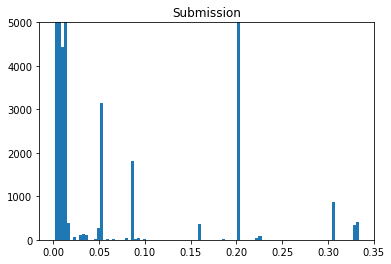

____________________________________________________________________________________________________
train feature =  ['ecfg']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.807671	valid_1's auc: 0.803217
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.807671	valid_1's auc: 0.803217
  auc =  0.803217244512349


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


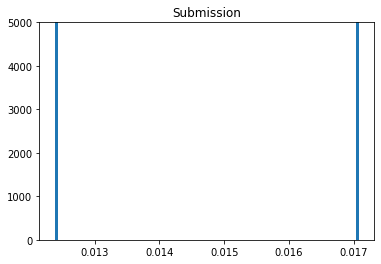

____________________________________________________________________________________________________
train feature =  ['etymd']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.827768	valid_1's auc: 0.819106
Did not meet early stopping. Best iteration is:
[35]	training's auc: 0.827768	valid_1's auc: 0.819106
  auc =  0.8191061145251308


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


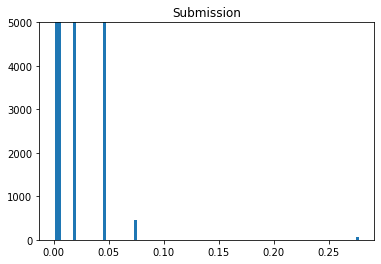

____________________________________________________________________________________________________
train feature =  ['flg_3dsmk']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.519639	valid_1's auc: 0.514641
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.519639	valid_1's auc: 0.514641
  auc =  0.5146409019058319


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


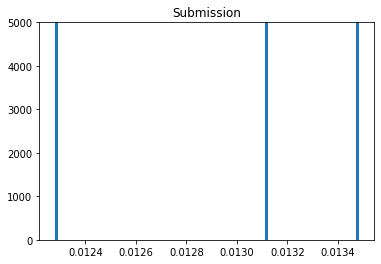

____________________________________________________________________________________________________
train feature =  ['hcefg']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.531846	valid_1's auc: 0.527164
Did not meet early stopping. Best iteration is:
[46]	training's auc: 0.531846	valid_1's auc: 0.527164
  auc =  0.5271637060997725


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


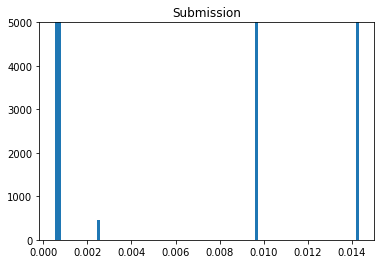

____________________________________________________________________________________________________
train feature =  ['iterm']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.51309	valid_1's auc: 0.513438
Did not meet early stopping. Best iteration is:
[11]	training's auc: 0.51309	valid_1's auc: 0.513438
  auc =  0.5134378565566591


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


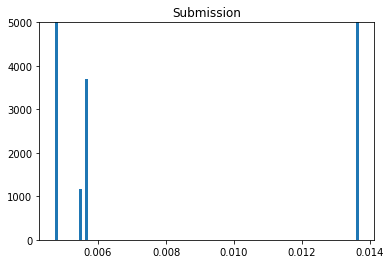

____________________________________________________________________________________________________
train feature =  ['mcc']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.915477	valid_1's auc: 0.913564
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.915477	valid_1's auc: 0.913564
  auc =  0.9135638071564156


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


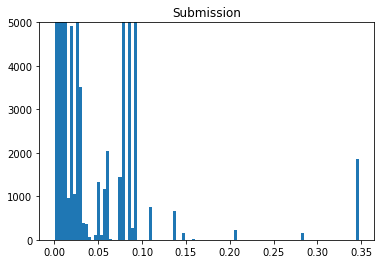

____________________________________________________________________________________________________
train feature =  ['mchno']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.935735	valid_1's auc: 0.93355
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.935735	valid_1's auc: 0.93355
  auc =  0.9335501922229847
  f1 =  0.1905521864028088
  confusion_matrix = 
 [[374778    641]
 [  4431    597]]


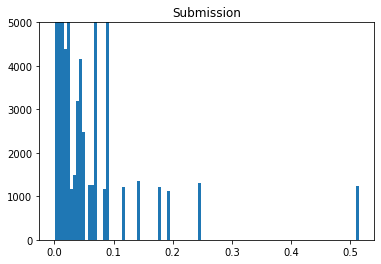

____________________________________________________________________________________________________
train feature =  ['ovrlt']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.509574	valid_1's auc: 0.507515
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.509574	valid_1's auc: 0.507515
  auc =  0.507515415822325


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


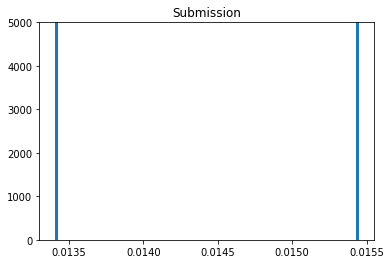

____________________________________________________________________________________________________
train feature =  ['scity']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.936872	valid_1's auc: 0.935089
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.936872	valid_1's auc: 0.935089
  auc =  0.935088742838834
  f1 =  0.11596820809248552
  confusion_matrix = 
 [[375232    187]
 [  4707    321]]


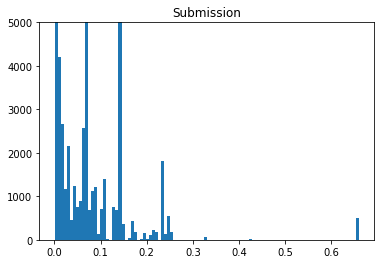

____________________________________________________________________________________________________
train feature =  ['stocn']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.92979	valid_1's auc: 0.929337
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.92979	valid_1's auc: 0.929337
  auc =  0.9293370479460654


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


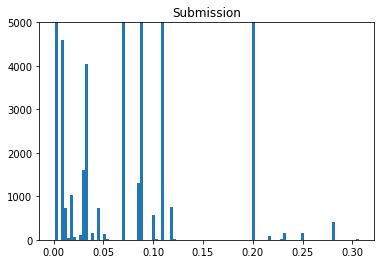

____________________________________________________________________________________________________
train feature =  ['stscd']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.636259	valid_1's auc: 0.631178
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.636259	valid_1's auc: 0.631178
  auc =  0.6311780318444002


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


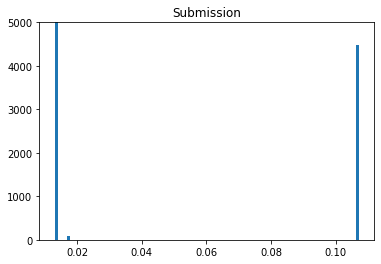

____________________________________________________________________________________________________
train feature =  ['loctm_hour']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.664749	valid_1's auc: 0.658603
Did not meet early stopping. Best iteration is:
[24]	training's auc: 0.664749	valid_1's auc: 0.658603
  auc =  0.6586027883481822


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


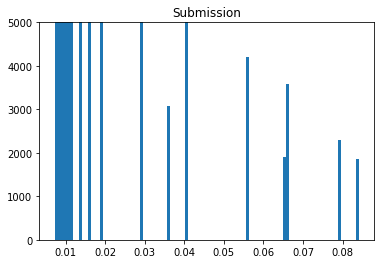

____________________________________________________________________________________________________
train feature =  ['loctm_min']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.52666	valid_1's auc: 0.509019
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.52666	valid_1's auc: 0.509019
  auc =  0.5090193750167236


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


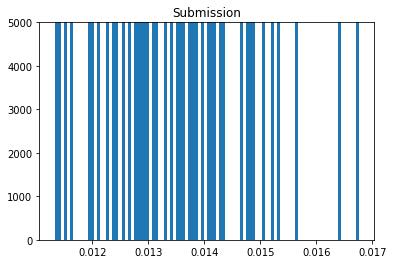

____________________________________________________________________________________________________
train feature =  ['bacno_cano']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.586374	valid_1's auc: 0.567203
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.586374	valid_1's auc: 0.567203
  auc =  0.5672031196167613


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


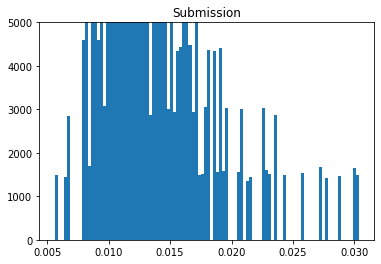

____________________________________________________________________________________________________
train feature =  ['mcc_csmcu']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.942538	valid_1's auc: 0.93016
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.942538	valid_1's auc: 0.93016
  auc =  0.9301602421918042
  f1 =  0.11026200873362446
  confusion_matrix = 
 [[375254    165]
 [  4725    303]]


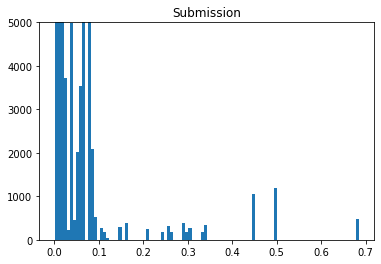

____________________________________________________________________________________________________
train feature =  ['stocn_scity']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.94671	valid_1's auc: 0.944216
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.94671	valid_1's auc: 0.944216
  auc =  0.9442163069696022
  f1 =  0.2641214207479267
  confusion_matrix = 
 [[374900    519]
 [  4184    844]]


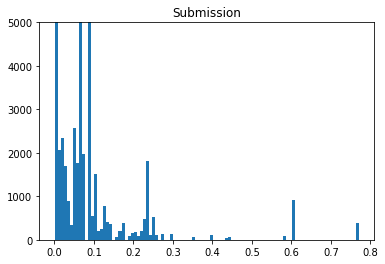

____________________________________________________________________________________________________
train feature =  ['conam_contp']
Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.793698	valid_1's auc: 0.777334
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.793698	valid_1's auc: 0.777334
  auc =  0.7773342712893015


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  f1 =  0.0
  confusion_matrix = 
 [[375419      0]
 [  5028      0]]


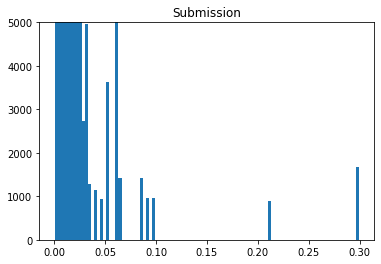

____________________________________________________________________________________________________


In [83]:
#script for time consistency
b = list(X_train.columns)# script
print('All feature =',X_train.columns)# script
for i in range(len(b)):# script
    model1_features = [b[i]]#script
    print('train feature = ',model1_features)
    train_df, y_train_df = X_train.loc[idxT,model1_features], Y_train[idxT]
    valid_df, y_valid_df = X_train.loc[idxV,model1_features], Y_train[idxV]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df)
    val_data = lgb.Dataset(valid_df, label=y_valid_df)
    
    clf = lgb.train(params,
                    trn_data,
                    num_boost_round= 50,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=50,
                    early_stopping_rounds = 200)
    pred = clf.predict(X_train.loc[idxV,model1_features])
    #print(pred[0])
    
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )    
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]   
    print( "  f1 = ", f1_score(y_valid_df, y_pre))
    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
    plt.hist(pred,bins=100)
    plt.ylim((0,5000))
    plt.title('Submission')
    plt.show()   
    print('_'*100)

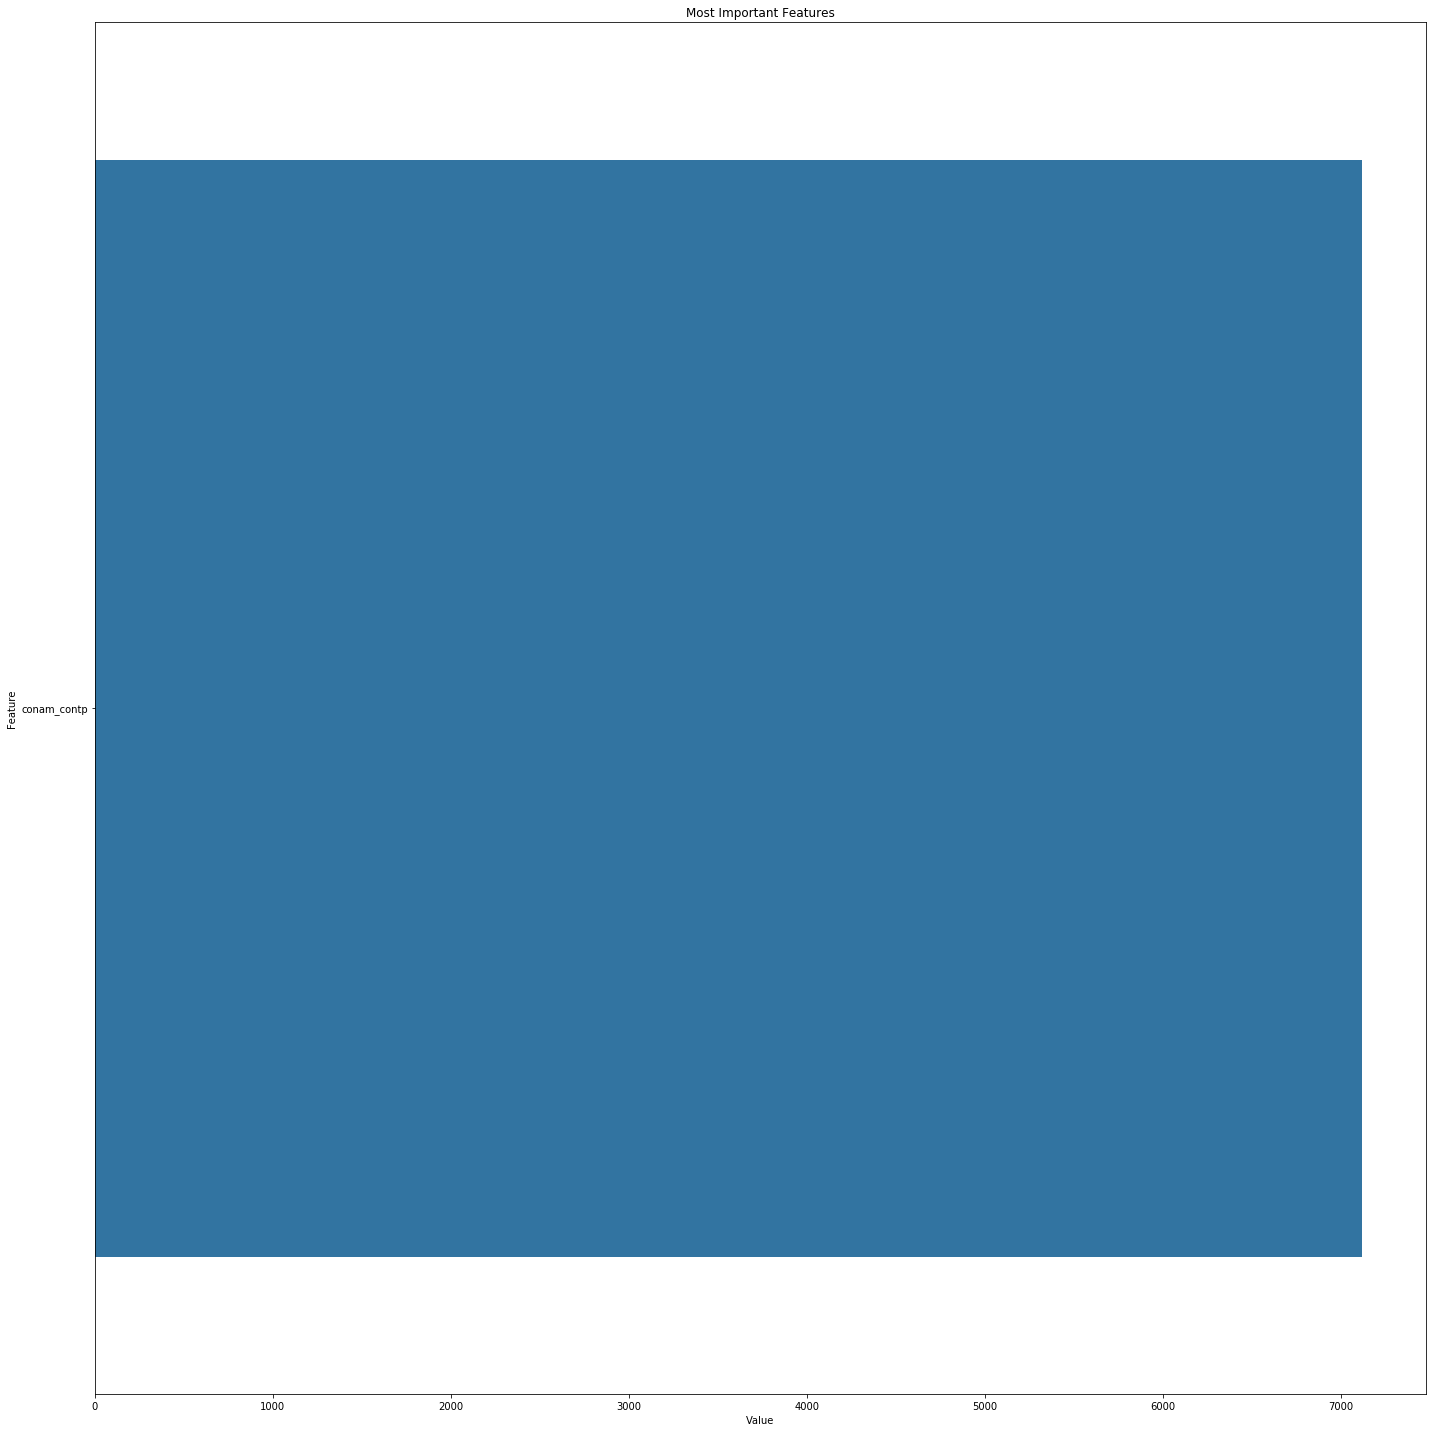

In [86]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),model1_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:100])
plt.title('Most Important Features')
plt.tight_layout()
plt.show()

In [0]:
# # 删除只出现过1次的商店和只消费过1次的卡。
# data_new = data_df.groupby(['acqic','stocn','scity','mcc','mchno']).filter(lambda x: (len(x) > 1))
# data_new = data_new.groupby(['bacno','cano']).filter(lambda x: (len(x) > 1))
# data_new = data_new.reset_index()
# data_new.shape

number of people =  95214


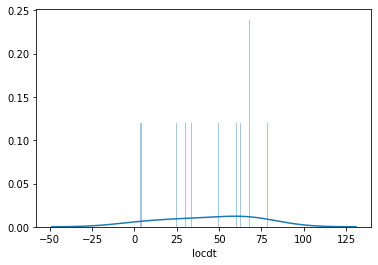

In [68]:
sns.distplot(df['locdt'][df['bacno'] == 1 ][df["fraud_ind"] == 0 ],label = 'Is Fraud',bins=100)


In [ ]:
a =[]
for index in df["bacno"]:
    if(len(df['locdt'][df["bacno"] == index ][df["fraud_ind"] == 1 ]) > 0 and len(df['locdt'][df["bacno"] == index ][df["fraud_ind"] == 0 ]) > 0):
        a.append(index)
x = pd.Series(a)
x.nunique()

In [6]:
print('number of bacno people in train = ',df['bacno'].nunique())
print("number of bacno people who is is fraud and is no fraud",8354/95214)
print("number of bacno people who is is fraud ",8643/95214)

number of bacno people in train =  95214
number of bacno people who is is fraud and is no fraud 0.08773919801709833
number of bacno people who is is fraud  0.0907744659398828


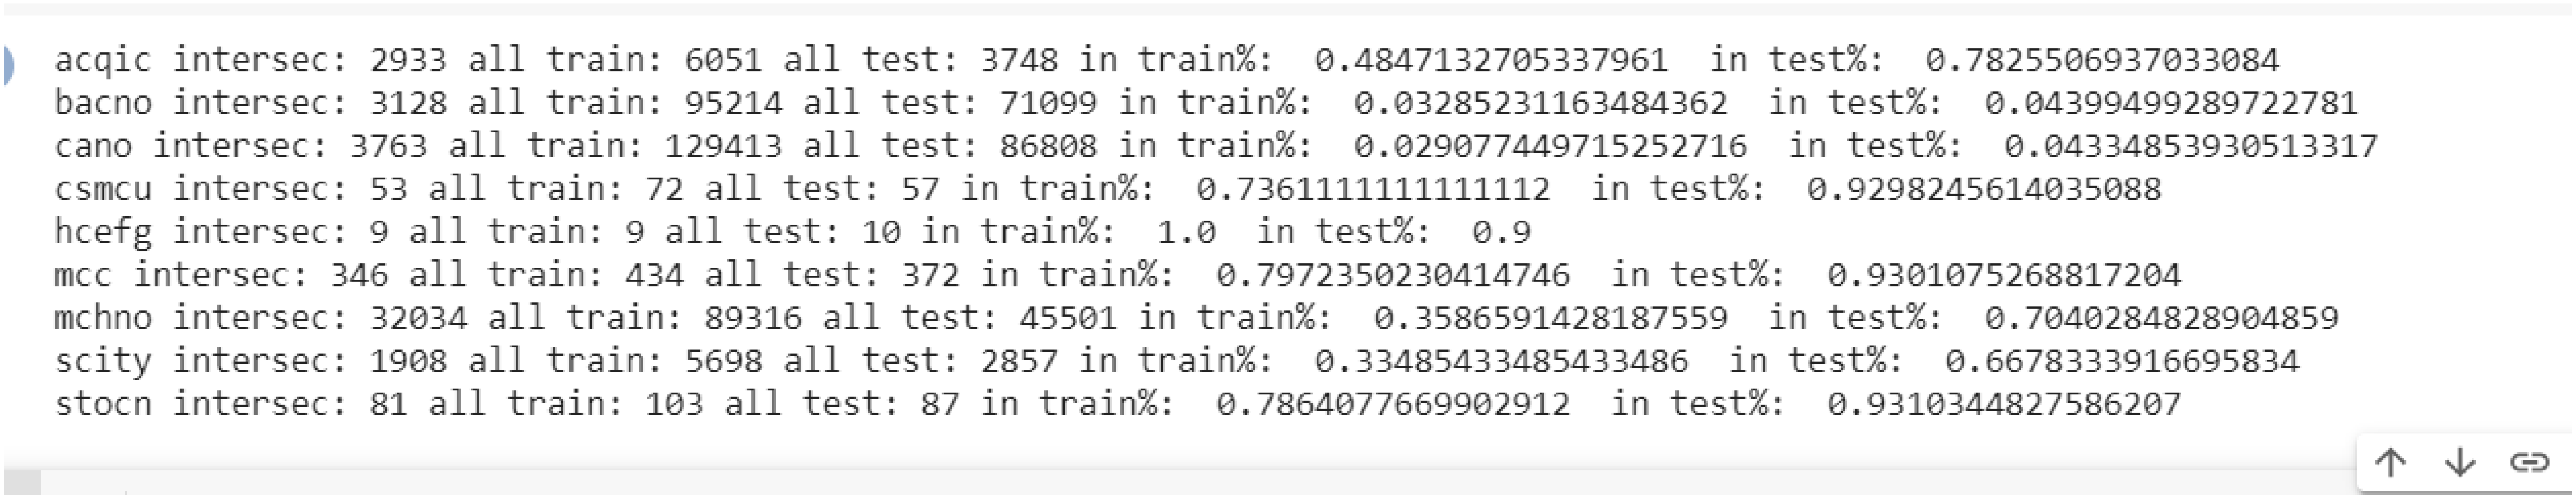

In [7]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

image = mpimg.imread('image.png') # 读取和代码处于同一目录下的 lena.png
# 此时 lena 就已经是一个 np.array 了，可以对它进行任意处理
image.shape #(512, 512, 3)
plt.figure(figsize=(8*10,4*10))
plt.imshow(image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
